In [91]:
%matplotlib inline
import time
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

In [219]:
class Grid():
    def __init__(self, n, m, n_home, m_home, delta, T, F):
        self.pheremones = np.zeros((n,m),dtype=float)
        self.food = np.zeros((n,m),dtype=float)
        self.occupancy = np.zeros((n,m), dtype=float)
        
        self.home = (n_home, m_home)
        self.food_drop = 0
        
#         self.food[55:65, 55:65] = 1  # For testing 
        self.place_food(T, F)
    
    def evaporate(self):
        self.pheremones -= delta*self.pheremones
    
    def place_food(self, T, F):
        n_food = int(T / F)
        side = int(F**0.5)
        placed = 0
        while placed < n_food:
            ctr = np.random.randint((1,2), 100)
            if ctr[0]-side >= 0 and ctr[0]+side < 100 and ctr[1]-side >= 0 and ctr[1]+side < 100:
#                 print(ctr)
                if np.sum(self.food[ctr[0]-side:ctr[0]+side, ctr[1]-side:ctr[1]+side]) == 0:
                    self.food[ctr[0]-side:ctr[0]+side, ctr[1]-side:ctr[1]+side] = 1
                    placed += 1
                
        
        

In [291]:
class Ant():
    def __init__(self, n, m, n_home, m_home, q, sigma_1, sigma_2, mu, grid):
        self.loc = (n, m)
        self.home = (n_home, m_home)
        
#         self.dir = self.randomize_dir(grid)
        self.dir = (1, 0)
        
        self.hasfood = False
        self.removed = False
    
    def randomize_dir(self, grid):
        p0 = grid.pheremones[self.loc[0], self.loc[1]+1] + grid.pheremones[self.loc[0]+1, self.loc[1]+1] + grid.pheremones[self.loc[0]-1, self.loc[1]+1]
        p1 = grid.pheremones[self.loc[0]+1, self.loc[1]] + grid.pheremones[self.loc[0]+1, self.loc[1]+1] + grid.pheremones[self.loc[0]+1, self.loc[1]-1]
        p2 = grid.pheremones[self.loc[0], self.loc[1]-1] + grid.pheremones[self.loc[0]+1, self.loc[1]-1] + grid.pheremones[self.loc[0]-1, self.loc[1]-1]
        p3 = grid.pheremones[self.loc[0]-1, self.loc[1]] + grid.pheremones[self.loc[0]-1, self.loc[1]+1] + grid.pheremones[self.loc[0]-1, self.loc[1]-1]
        
        ps = p0 + p1 + p2 + p3
        if ps != 0:
            p0 /= ps
            p1 /= ps
            p2 /= ps
            p3 /= ps
        
            did = np.random.choice([0,1,2,3], 1, p=[p0,p1,p2,p3])
        else:
            did = np.random.choice(4, 1)
        if did == 0:
            direction = (0, 1)
        elif did == 1:
            direction = (1, 0)
        elif did == 2:
            direction = (0, -1)
        elif did == 3:
            direction = (-1, 0)
        return direction
    
    def move(self, grid):
        if self.loc[0] == 0 or self.loc[1] == 0 or self.loc[0] == grid.occupancy.shape[0]-1 or self.loc[1] == grid.occupancy.shape[1]-1:
            self.removed = True
#             print("Boarder!")
        if not self.removed:
            left_loc = (self.loc[0]+self.dir[1]+self.dir[0], self.loc[1]-self.dir[0]+self.dir[1])
            front_loc = (self.loc[0]+self.dir[0], self.loc[1]+self.dir[1])
            right_loc = (self.loc[0]-self.dir[1]+self.dir[0], self.loc[1]+self.dir[0]+self.dir[1])
        
            lp = grid.pheremones[left_loc[0], left_loc[1]]
            fp = grid.pheremones[front_loc[0], front_loc[1]]
            rp = grid.pheremones[right_loc[0], right_loc[1]]
            
            p_m = 0.5 * (1 + np.tanh((lp + fp + rp)/100 - 1))
            if np.random.choice(2, 1, p=[1-p_m,p_m]):
                c = (mu + lp)**2 + (mu + fp)**2 + (mu + rp)**2
                p_left = 1/c * (mu + lp)**2
                p_front = 1/c * (mu + fp)**2
                p_right = 1/c * (mu + rp)**2
                
                next_loc = np.random.choice(["left_loc","right_loc","front_loc"], 1, p=[p_left,p_right,p_front])
                if next_loc == "left_loc" and grid.occupancy[left_loc[0], left_loc[1]] < Am:
                    grid.occupancy[self.loc[0], self.loc[1]] -= 1
                    self.loc = left_loc
                    grid.occupancy[self.loc[0], self.loc[1]] += 1
                elif next_loc == "front_loc" and grid.occupancy[front_loc[0], front_loc[1]] < Am:
                    grid.occupancy[self.loc[0], self.loc[1]] -= 1
                    self.loc = front_loc
                    grid.occupancy[self.loc[0], self.loc[1]] += 1
                elif next_loc == "right_loc" and grid.occupancy[right_loc[0], right_loc[1]] < Am:
                    grid.occupancy[self.loc[0], self.loc[1]] -= 1
                    self.loc = right_loc
                    grid.occupancy[self.loc[0], self.loc[1]] += 1

                    
                if grid.food[self.loc[0], self.loc[1]] > 0:
                    if not self.hasfood:
                        g.food[self.loc[0], self.loc[1]] -= 1
                        self.dir = (self.dir[0]*-1, self.dir[1]*-1) # Flips direction
                        self.hasfood = True
                        
                        
                if (self.home[0]-1 < self.loc[0] < self.home[0]+1) and (self.home[1]-1 < self.loc[1] < self.home[1]+1) and self.hasfood:
                    self.hasfood = False
                    grid.occupancy[self.home[0], self.home[1]] -= 1
                    grid.food_drop += 1
                    self.removed = True
#                     print("Brought back food!")
                    
                    
            if self.hasfood:
                if grid.pheremones[self.loc[0], self.loc[1]] < sigma_2:
                    grid.pheremones[self.loc[0],self.loc[1]] += q
            else:
                if grid.pheremones[self.loc[0], self.loc[1]] < sigma_1:
                    grid.pheremones[self.loc[0], self.loc[1]] += 1.
    
    def plot(self):
        if self.hasfood:
            color = 'red'
        else:
            color = 'green'
        plt.scatter(self.loc[0], self.loc[1], color=color)
        

In [358]:
def simulate(g, ants, q, sigma_1, sigma_2, mu, delta, Am, Nb, iterations=100):
    fitness = 0
    fig, _ = plt.subplots(figsize=(10, 20))
    
    for _ in range(iterations):
        for _ in range(Nb):
            if g.occupancy[g.home[0], g.home[1]] < Am:
                ants.append(Ant(g.home[0], g.home[1], g.home[0], g.home[1], q, sigma_1, sigma_2, mu, g))
                g.occupancy[g.home[0], g.home[1]] += 1
                
        for ant in ants:
            ant.move(g)
            if ant.removed:
                ants.remove(ant)
                continue

        g.evaporate()
        
        fitness += (g.food_drop / np.sum(g.occupancy))
        g.food_drop = 0
        
        # Plot
        plt.imshow(g.pheremones.T)
#         plt.imshow(g.food.T)
        plt.scatter(g.home[0], g.home[1], color='blue')
#         for y in range(g.food.shape[0]):
#             for x in range(g.food.shape[1]):
#                 if g.food[y,x] == 1:
#                     plt.scatter(y, x, color='yellow')
#         for ant in ants:
#             ant.plot()
        
        # Animaiton part
        clear_output(wait=True) # Clear output for dynamic display
        display(fig)            # Reset display
        fig.clear()             # Prevent overlapping and layered plots
        time.sleep(0.0001)      # Sleep to allow animation to catch up
    
    return fitness

In [356]:
def optimize_parameters(mins, maxs, m, n, delta, T, F, Am, Nb, tau, e, param_collection, iterations=500):
    avg_fitness = 0
    indiv_fitness = list()
    
    for i in range(N):
        if len(param_collection) != N:
            rands = np.random.rand(5)
            params = rands * maxs + (1-rands) * mins
            param_collection.append(params)
        else:
            params = param_collection[i]
        
        print("Params:", params)
        q = params[0]
        sigma_1 = params[1]
        sigma_2 = params[2]
        mu = params[3]
        delta = params[4]

        g = Grid(100, 100, m, n, delta, T, F)
        ants = list()
        tic = time.perf_counter()
        f = simulate(g, ants, q, sigma_1, sigma_2, mu, delta, Am, Nb, iterations)
        toc = time.perf_counter()
        print("Fitness of N {}:".format(i), f)
        print(f"Time to simulate 1 N in {toc - tic:0.4f} seconds")
        indiv_fitness.append(f)
        avg_fitness += f

    avg_fitness /= N
    print("Generation fitness:", avg_fitness)

    for i in range(N):
        if indiv_fitness[i] < avg_fitness:
            param_collection.pop(i)
            gen_new = np.random.choice([0,1], 1, p=[1-tau,tau])
            if gen_new:
                rands = np.random.rand(5)
                params = rands * maxs + (1-rands) * mins
                param_collection.insert(i, params)
            else:
                param_id = np.random.choice(len(param_collection))
                params = param_collection[param_id]
                plus_minus_e = np.random.choice(2)
                if plus_minus_e:
                    params = params*(1+e)
                else:
                    params = params*(1-e)
                params = np.maximum(mins, params)
                params = np.minimum(maxs, params)
                param_collection.insert(i, params)
    
    return param_collection

KeyboardInterrupt: 

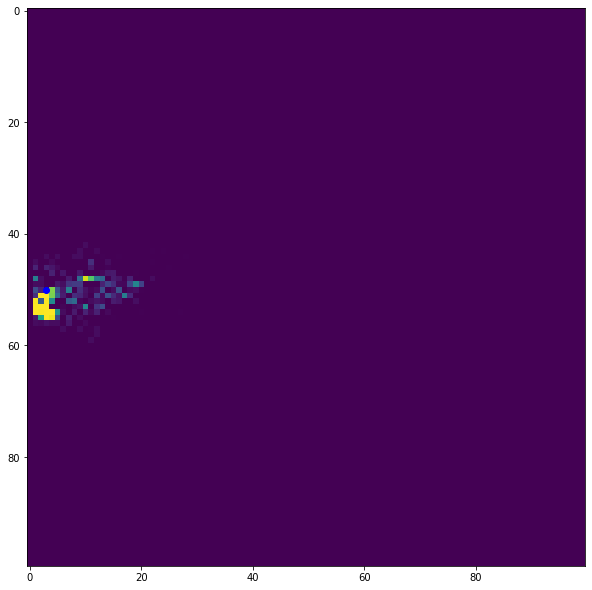

In [359]:
q_min = 1
sigma_min = 0.0001
mu_min = 0.0001
delta_min = 0.001

q_max = 50
sigma_max = 1000
mu_max = 50
delta_max = 1

Am = 30
Nb = 10

m = 3
n = 50

T = 200
F = 4

G = 30
N = 16

mins = np.array([q_min, sigma_min, sigma_min, mu_min, delta_min])
maxs = np.array([q_max, sigma_max, sigma_max, mu_max, delta_max])

tau = 0.5
e = 0.2

param_collection = list()
    
for i in range(G):
    print("Generation", i)
    param_collection = optimize_parameters(mins, maxs, m, n, delta, T, F, Am, Nb, tau, e, param_collection, iterations=1000)
    print(param_collection)


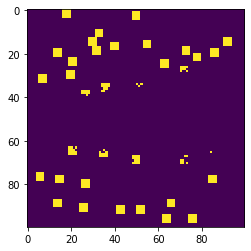

In [275]:
 plt.imshow(g.food.T)

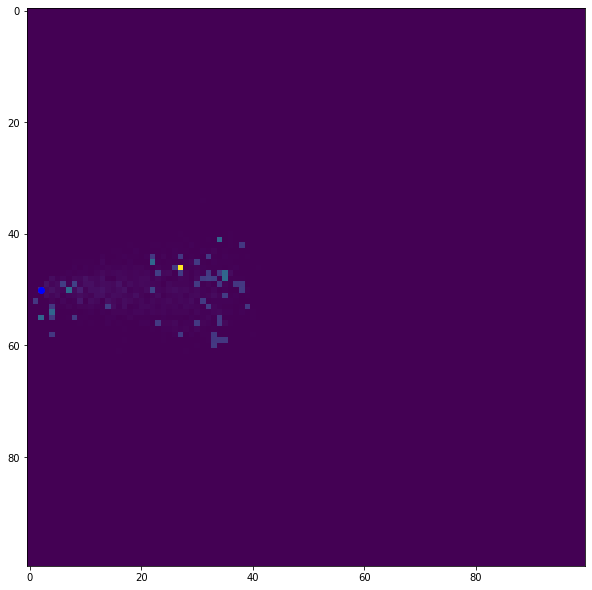

In [ ]:
# q = 35
# sigma_1 = 55
# sigma_2 = 250
# mu = 3.7
# delta = 0.06679
# 40.73883399 275.33197267 992.53989214  50.           0.99521751
   
q = 40.73883399
sigma_1 = 275.33197267
sigma_2 = 992.53989214
mu = 50
delta = 0.99521751

Am = 30
Nb = 10

m = 2
n = 50

T = 200
F = 4

g = Grid(100, 100, m, n, delta, T, F)
ants = list()

tic = time.perf_counter()
fitness = simulate(g, ants, q, sigma_1, sigma_2, mu, delta, Am, Nb, iterations=500)
toc = time.perf_counter()
print("Fitness:", fitness)
print(f"Time to simulate 1 N in {toc - tic:0.4f} seconds")